## Preparing Training DATA

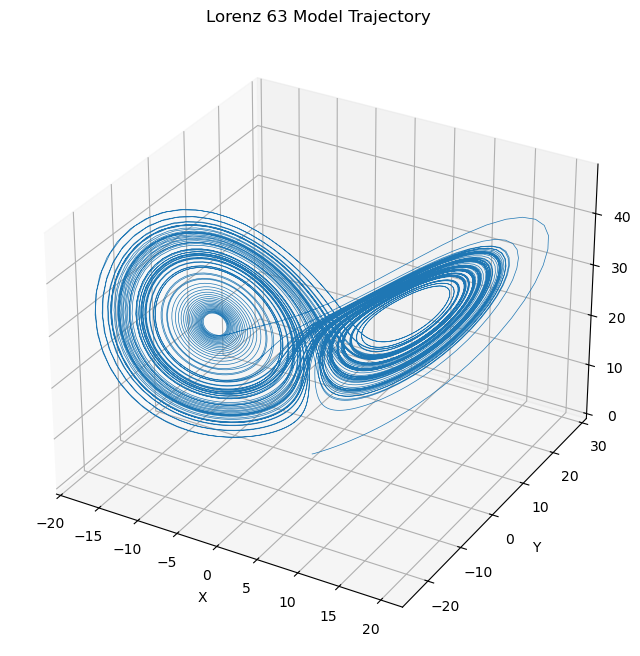

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Parameters for the Lorenz system
sigma = 10.0
rho   = 28.0
beta  = 8.0 / 3.0

# Define the Lorenz system of differential equations
def lorenz63(t, state):
    x, y, z = state
    dxdt    = sigma * (y - x)
    dydt    = x * (rho - z) - y
    dzdt    = x * y - beta * z
    return [dxdt, dydt, dzdt]

# Initial state and time settings
initial_state = [0.0, 0.1, 0.0]
t_start       = 0.0
t_end         = 10000 * 0.01  # 5000 steps with a time increment of 0.01
t_eval        = np.arange(t_start, t_end, 0.01)

# Integrate the Lorenz system
solution = solve_ivp(lorenz63, [t_start, t_end], initial_state, t_eval=t_eval, method='RK45')

# Extract the results
x, y, z = solution.y

# Plot results
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot(x, y, z, lw=0.5)
ax.set_title("Lorenz 63 Model Trajectory")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.show()

## Training with the first 7000 (max) steps

In [41]:
from Reservoir_Computing import reservoir


# Dictionary the models 
# d is used to save the pre-trained models
# 100 different models are saved for the following prediction task
model_size = 100 # how many different models are trained 
d          = {}
count      = 0 
# stack data
data               = np.array(np.vstack((x,y,z)))
dim_var, dim_time  = data.shape

while True:
    a                  = np.random.choice([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9], 1, replace=False) # leaking rate 
    data_length        = np.random.choice(range(5000,7000), 1, replace=False)                      # [5000,7000] steps as the minimum/maximum length for traning the model
    resSize            = np.random.choice(range(50,100), 1,  replace=False)                        # reservoir size (bigger leads to more complicated model)  
    testLen            = 10                                                                        # using the subsequent 10 steps for validation. e.g., training ends at 500, then use 501-510 for validation 
    model              = reservoir(trainLen= int(data_length), testLen= testLen, initLen= 10, inSize=int(dim_var), outSize = int(dim_var),
                                   resSize = int(resSize),          a = a,         seed = 0,
                                       reg = 1e1)
    Y, x_record, Win, W, Wout,mse   = model.training_testing(data.T)

    if (np.mean(mse[:3]) < 0.02) & (count<model_size):  
        # To keep a model, the mean MSE (x,y and z) at the validation set should be smaller than 0.02 
        d["model{0}".format(count)]    = model, Win, W, Wout, "a="+str(a), "resSize="+str(resSize), "testLen="+str(testLen)  
        count = count+1
        print(count)
        print(np.mean(mse[:3]))
    elif count>=model_size:
        break

/var/folders/x1/nb2x5h5j08b2xx8xkc64r43m0000gn/T/ipykernel_21562/1208941017.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  model              = reservoir(trainLen= int(data_length), testLen= testLen, initLen= 10, inSize=int(dim_var), outSize = int(dim_var),
/var/folders/x1/nb2x5h5j08b2xx8xkc64r43m0000gn/T/ipykernel_21562/1208941017.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  resSize = int(resSize),          a = a,         seed = 0,


1
0.018302930381955674
2
0.009406381808918908
3
0.004015049217588189
4
0.001441658292265002
5
0.00892855810438622
6
0.004850020306311514
7
0.003977880453627874
8
0.014275182937604805
9
0.011683113721448236
10
0.005775772523563423
11
0.013141111965760711
12
0.002571554129701711
13
0.014245464307818263
14
0.0021532326414790363
15
0.0025795204188797586
16
0.016888177885275465
17
0.017003678482887776
18
0.006443986594597041
19
0.017246129097119433
20
0.008220973052574564
21
0.0009756941063587137
22
0.014441940879693319
23
0.008793799021444655
24
0.019460237359209556
25
0.0066170146653281685
26
0.008182442035451947
27
0.007385741933100279
28
0.013095701268355261
29
0.012302886603807765
30
0.014073325271747018
31
0.0038534674540640864
32
0.005702296153632269
33
0.00370250830927551
34
0.006528230954395822
35
0.008396517234876959
36
0.008814558994008815
37
0.01575635658694107
38
0.01285351503234407
39
0.006624169987896421
40
0.0030140587755280806
41
0.010458976868273415
42
0.017546553844602863

## Testing results

In [45]:
# initial time: t=7000 (the last step of training data)
# forecast time: 500
# for each model, we only generates 1 ensemble 

forecast_time = 500 
predict       = np.zeros((3,100,forecast_time))
for count in range(model_size):
    Win  = d["model{0}".format(count)][1]
    W    = d["model{0}".format(count)][2]
    Wout = d["model{0}".format(count)][3] 
    out  = d["model{0}".format(count)][0].prediction(data[:,:7001].T,Win,W,Wout,ensemble_size=1,forecast_time=forecast_time)
    predict[:,count,:] = np.squeeze(out)  

(-1.0, 500.0)

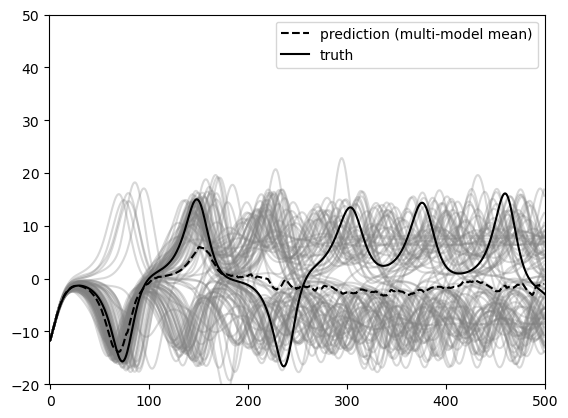

In [46]:
plt.figure()
plt.plot(predict[0,:,:].T,'gray',alpha=0.3)
plt.plot(np.median(predict[0,:,:],axis=0),'k--',label='prediction (multi-model mean)')
plt.plot(data[0,7000:],'k',label='truth')
plt.legend()
plt.ylim([-20,50])
plt.xlim([-1,500])